In [1]:
from HeaderP import *

from scipy.ndimage import gaussian_filter1d
from scipy.fft import fft, fftfreq
from scipy.signal import savgol_filter
from astropy.timeseries import LombScargle


In [2]:
def processdata(df, R0lim=[7,9]):
    df_sel = df.loc[(df['R0']>R0lim[0])&(df['R0']<R0lim[1])]
    dr = df['R']-df['R0']
    age = df['AGE']
    return age.values, dr.values

In [5]:
def SlideMed(age, dr, window, slide,fn=np.median):
    age, dr = np.array(age), np.array(dr)
    minage, maxage = min(age), max(age)
    npoints = int((maxage-minage)/slide)
    medage = np.zeros(npoints)*np.nan
    meddr = np.zeros(npoints)*np.nan
    for i in trange(npoints):
        if i==0:
            m_w = (age<window)
        elif i==npoints-1:
            m_w = (age>(maxage-window))
        else:
            m_w = ((age>(i*slide-window+minage))&(age<(i*slide+window+minage)))
        #print(sum(m_w))
        medage[i], meddr[i] = np.mean(age[m_w]), fn(dr[m_w])
    m_nan = (meddr==meddr)
    medage, meddr = medage[m_nan], meddr[m_nan]
    return medage, meddr
        

# Test1

In [6]:
sqrttest = readfits('2021-01-24_mw_FAnders_test1.fits')

  0%|          | 0/294 [00:00<?, ?it/s]/opt/homebrew/anaconda3/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/homebrew/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
  0%|          | 0/294 [00:00<?, ?it/s]/opt/homebrew/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:262: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/opt/homebrew/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:222: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/opt/homebrew/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:254: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcoun

(1, 30)

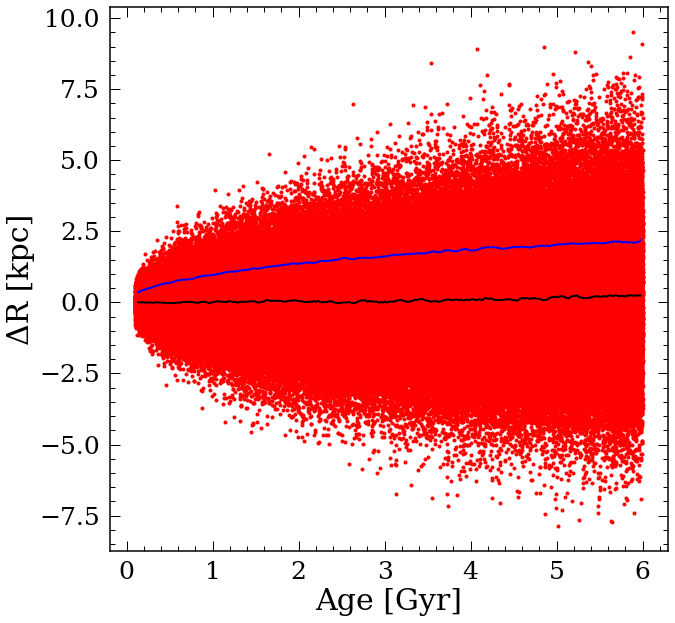

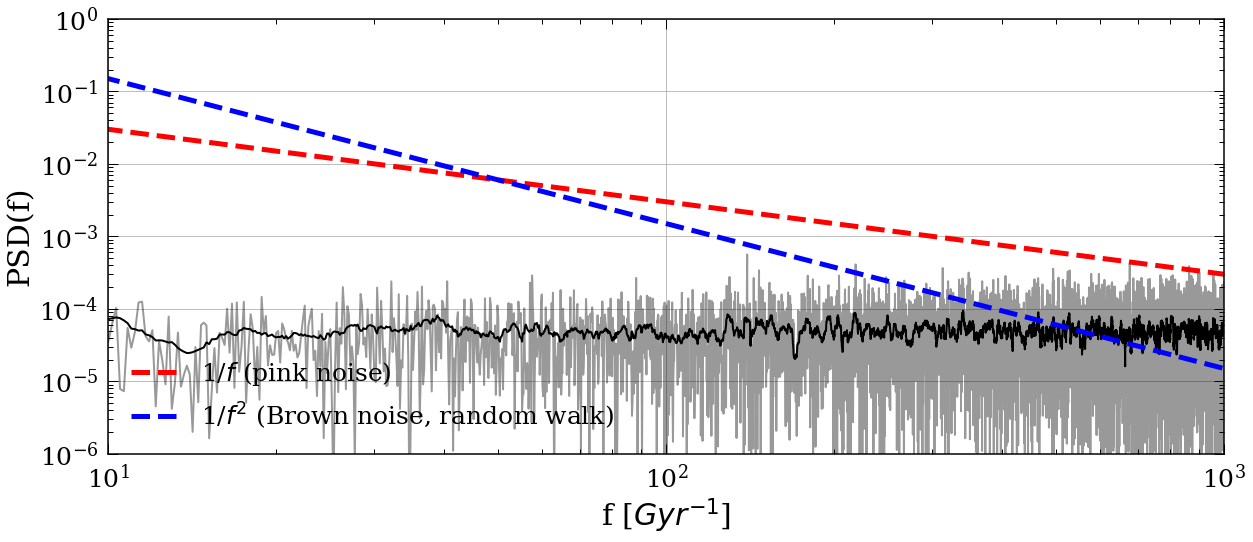

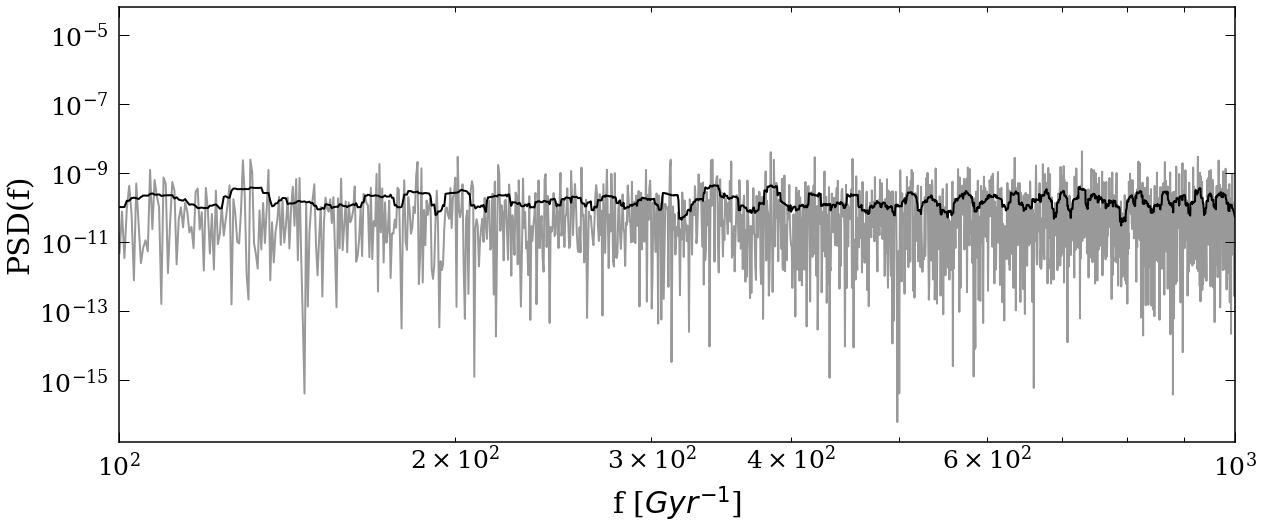

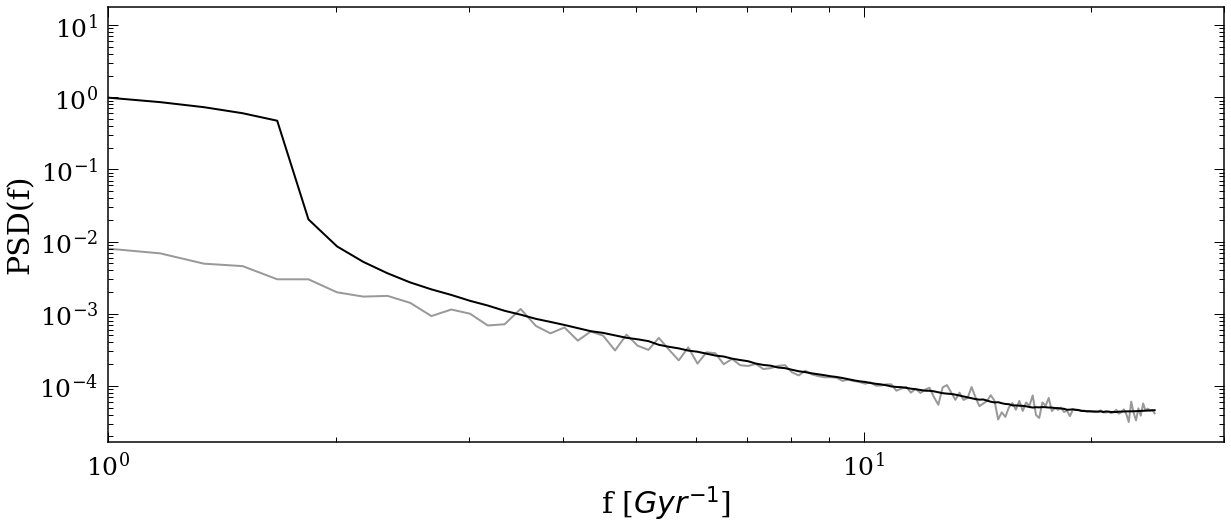

In [24]:
age, dr = processdata(sqrttest)

age_order, dr_order = zip(*sorted(zip(age, dr)))
age_smooth, dr_smooth = SlideMed(age_order, dr_order, 0.05, 0.02)
age_std, dr_std = SlideMed(age_order, dr_order, 0.05, 0.02,fn=np.std)


plt.figure()
plt.plot(age, dr,'r.')
plt.plot(age_smooth, dr_smooth,'k-')
plt.plot(age_std, dr_std,'b-')
plt.xlabel('Age [Gyr]')
plt.ylabel('ΔR [kpc]')

### FFT
N = len(age)
T = max(age)/N
yf = fft(dr)

xf = fftfreq(N, T)[:N//2]

plt.figure(figsize=(20,8))
PSD = 2.0/N * np.abs(yf[0:N//2])
plt.loglog(xf,PSD**2,'k-',alpha=0.4)

PSD_smooth = savgol_filter(PSD**2, 21, 1)
plt.loglog(xf,PSD_smooth,'k-')

A = 0.3
plt.plot(xf, A/xf, 'r--',label='1/$f$ (pink noise)',linewidth=5)
plt.plot(xf, A*50/xf**2, 'b--',label='1/$f^2$ (Brown noise, random walk)',linewidth=5)
plt.grid()
plt.xlim([10,1e3])
plt.ylim([1e-6,1])
plt.xlabel('f [$Gyr^{-1}$]')
plt.ylabel('PSD(f)')
plt.legend(loc=3)


### LG
power = LombScargle(age_order, dr_order).power(np.linspace(0.1,1e3,2000))
plt.figure(figsize=(20,8))
PSD = np.array(power,dtype=float)
plt.loglog(np.linspace(0.1,1e3,2000), PSD**2,'k-',alpha=0.4)
PSD_smooth = savgol_filter(PSD**2, 21, 1)
plt.loglog(np.linspace(0.1,1e3,2000),PSD_smooth,'k-')
plt.xlabel('f [$Gyr^{-1}$]')
plt.ylabel('PSD(f)')
plt.xlim([100,1e3])
#plt.ylim([0,1])

### LG on std
N = len(age_std)
T = max(age_std)/N
yf = fft(dr_std)
xf = fftfreq(N, T)[:N//2]
PSD = 2.0/N * np.abs(yf[0:N//2])
plt.figure(figsize=(20,8))
plt.loglog(xf,PSD**2,'k-',alpha=0.4)
PSD_smooth = savgol_filter(PSD**2, 21, 1)
plt.loglog(xf,PSD_smooth,'k-')
plt.xlabel('f [$Gyr^{-1}$]')
plt.ylabel('PSD(f)')
plt.xlim([1,30])

# test 2

In [7]:
sqrttest = readfits('2021-01-24_mw_FAnders_test2.fits')

  0%|          | 0/2359 [00:00<?, ?it/s]/opt/homebrew/anaconda3/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/homebrew/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
100%|██████████| 2359/2359 [00:00<00:00, 5023.03it/s]
<ipython-input-8-0d694c1d414c>:27: RuntimeWarning: divide by zero encountered in true_divide
  plt.plot(xf, A/xf, 'r--',label='1/$f$ (pink noise)',linewidth=5)
<ipython-input-8-0d694c1d414c>:28: RuntimeWarning: divide by zero encountered in true_divide
  plt.plot(xf, A*50/xf**2, 'b--',label='1/$f^2$ (Brown noise, random walk)',linewidth=5)


(100, 1000.0)

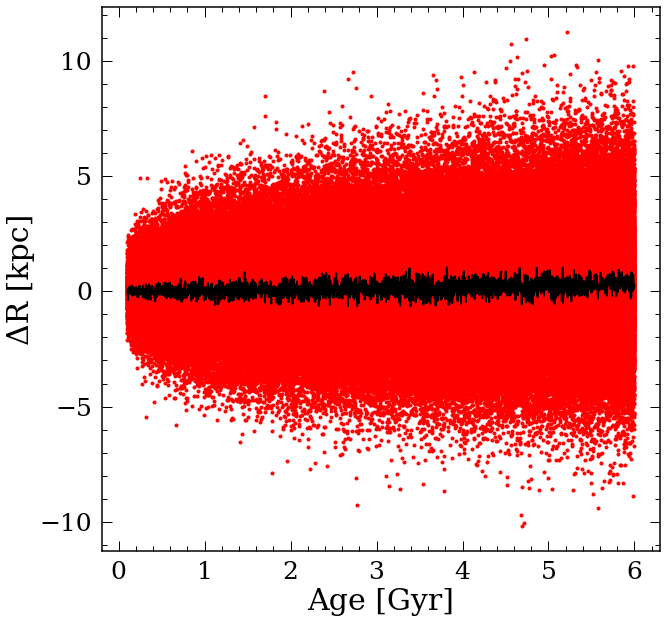

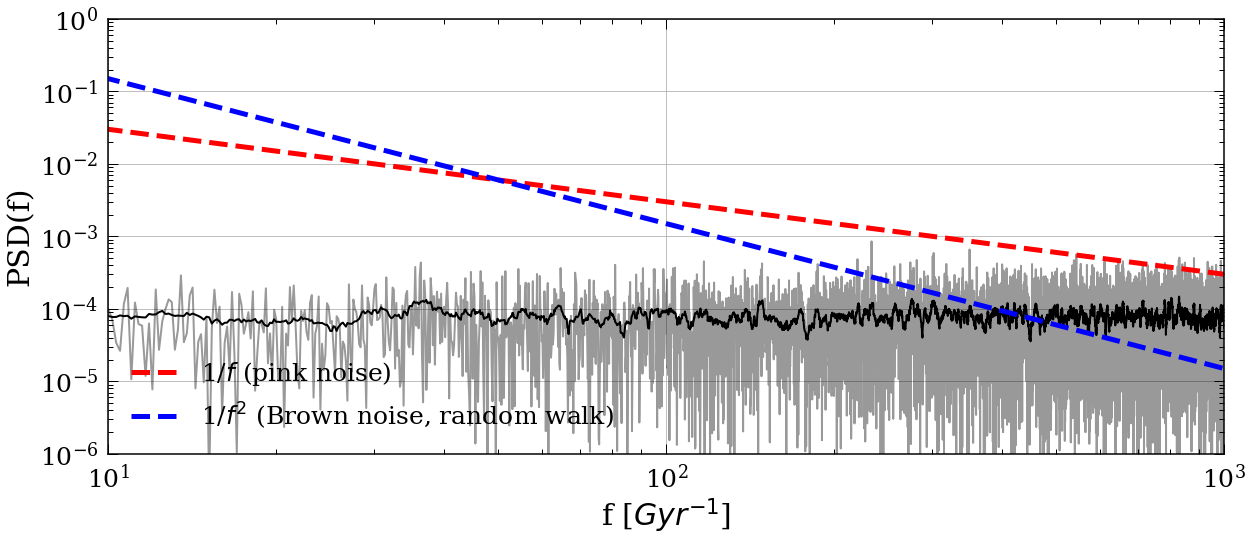

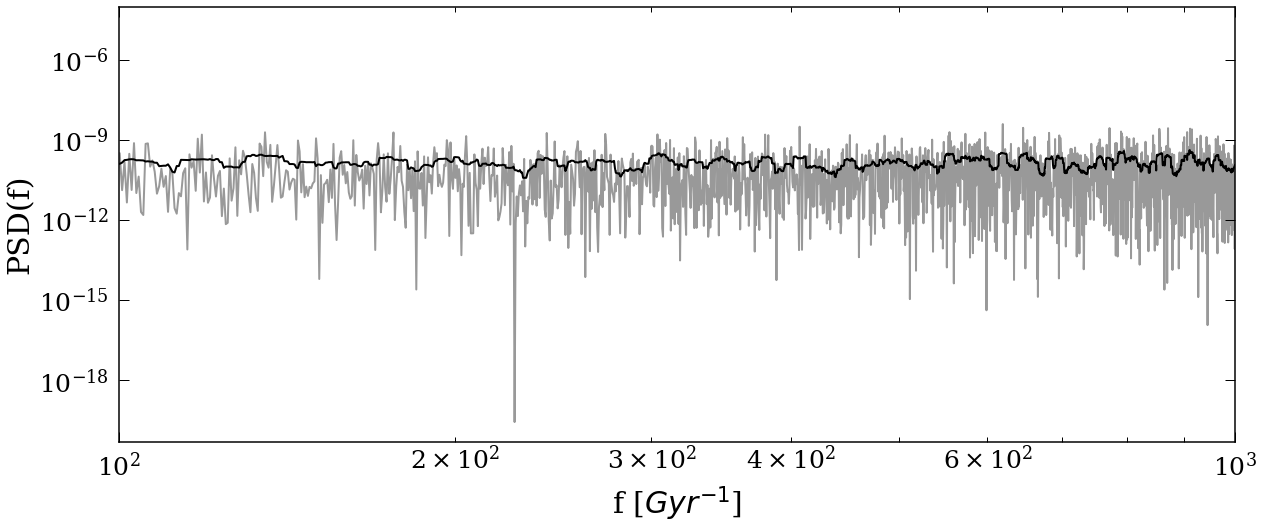

In [8]:
age, dr = processdata(sqrttest)

age_order, dr_order = zip(*sorted(zip(age, dr)))
age_smooth, dr_smooth = SlideMed(age_order, dr_order, 0.0025/2, 0.0025)

plt.figure()
plt.plot(age, dr,'r.')
plt.plot(age_smooth, dr_smooth,'k-')
plt.xlabel('Age [Gyr]')
plt.ylabel('ΔR [kpc]')

### FFT
N = len(age)
T = max(age)/N
yf = fft(dr)

xf = fftfreq(N, T)[:N//2]

plt.figure(figsize=(20,8))
PSD = 2.0/N * np.abs(yf[0:N//2])
plt.loglog(xf,PSD**2,'k-',alpha=0.4)

PSD_smooth = savgol_filter(PSD**2, 21, 1)
plt.loglog(xf,PSD_smooth,'k-')

A = 0.3
plt.plot(xf, A/xf, 'r--',label='1/$f$ (pink noise)',linewidth=5)
plt.plot(xf, A*50/xf**2, 'b--',label='1/$f^2$ (Brown noise, random walk)',linewidth=5)
plt.grid()
plt.xlim([10,1e3])
plt.ylim([1e-6,1])
plt.xlabel('f [$Gyr^{-1}$]')
plt.ylabel('PSD(f)')
plt.legend(loc=3)


### LG
power = LombScargle(age_order, dr_order).power(np.linspace(0.1,1e3,2000))
plt.figure(figsize=(20,8))
PSD = np.array(power,dtype=float)
plt.loglog(np.linspace(0.1,1e3,2000), PSD**2,'k-',alpha=0.4)
PSD_smooth = savgol_filter(PSD**2, 21, 1)
plt.loglog(np.linspace(0.1,1e3,2000),PSD_smooth,'k-')
plt.xlabel('f [$Gyr^{-1}$]')
plt.ylabel('PSD(f)')
plt.xlim([100,1e3])
#plt.ylim([0,1])

# test3

In [9]:
sqrttest = readfits('2021-01-24_mw_FAnders_test3.fits')

100%|██████████| 2399/2399 [00:02<00:00, 1143.47it/s]
<ipython-input-10-0d694c1d414c>:27: RuntimeWarning: divide by zero encountered in true_divide
  plt.plot(xf, A/xf, 'r--',label='1/$f$ (pink noise)',linewidth=5)
<ipython-input-10-0d694c1d414c>:28: RuntimeWarning: divide by zero encountered in true_divide
  plt.plot(xf, A*50/xf**2, 'b--',label='1/$f^2$ (Brown noise, random walk)',linewidth=5)


(100, 1000.0)

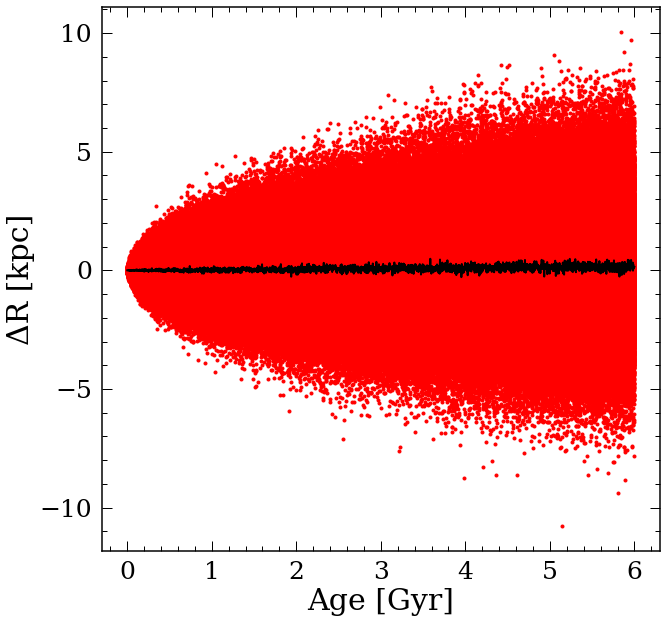

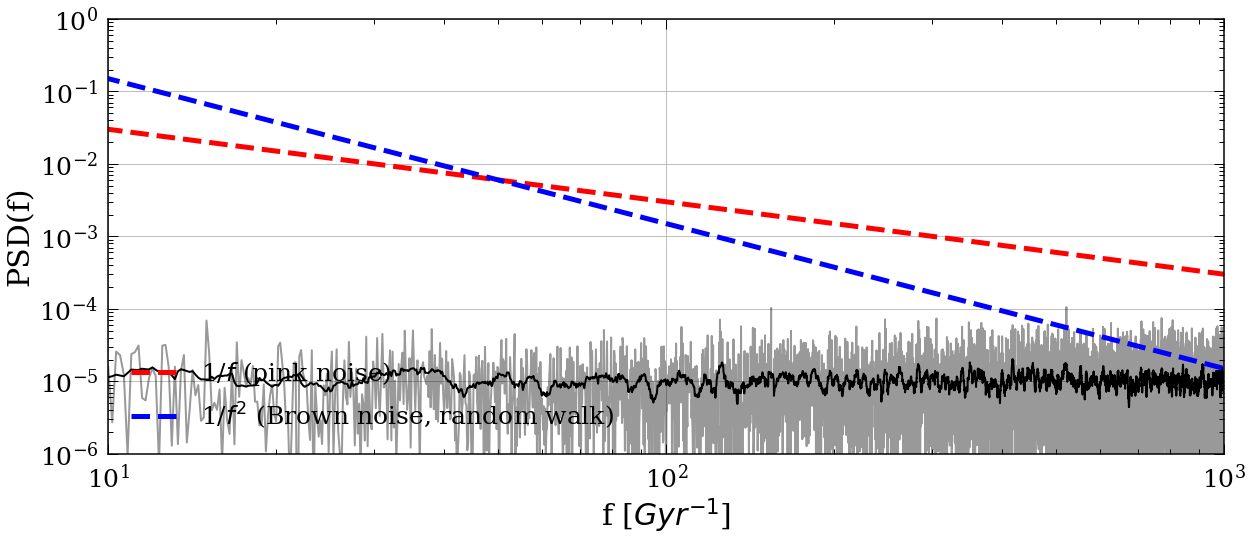

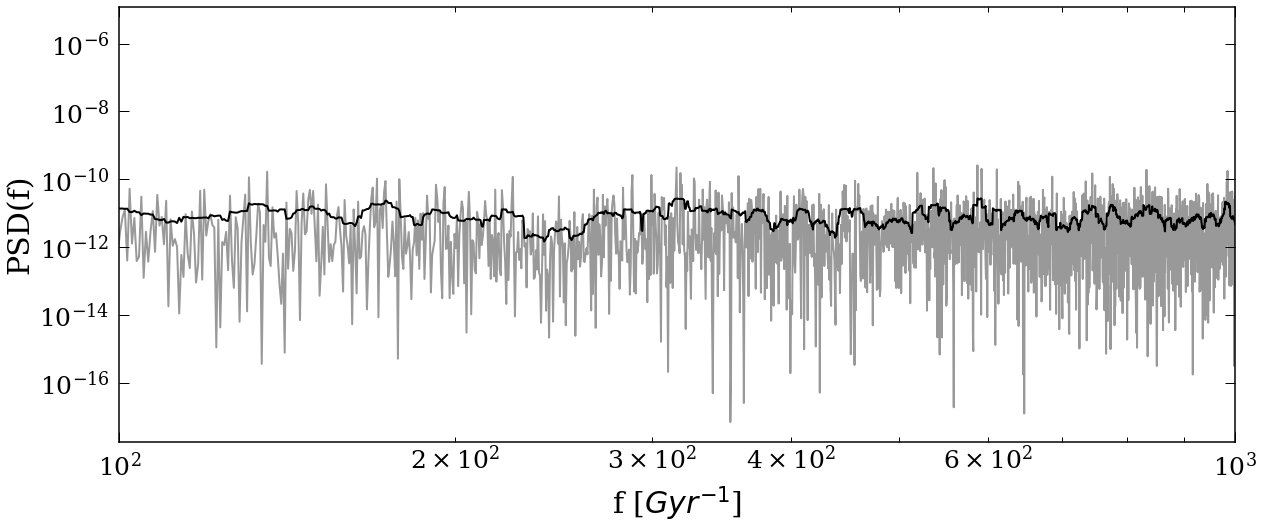

In [10]:
age, dr = processdata(sqrttest)

age_order, dr_order = zip(*sorted(zip(age, dr)))
age_smooth, dr_smooth = SlideMed(age_order, dr_order, 0.0025/2, 0.0025)

plt.figure()
plt.plot(age, dr,'r.')
plt.plot(age_smooth, dr_smooth,'k-')
plt.xlabel('Age [Gyr]')
plt.ylabel('ΔR [kpc]')

### FFT
N = len(age)
T = max(age)/N
yf = fft(dr)

xf = fftfreq(N, T)[:N//2]

plt.figure(figsize=(20,8))
PSD = 2.0/N * np.abs(yf[0:N//2])
plt.loglog(xf,PSD**2,'k-',alpha=0.4)

PSD_smooth = savgol_filter(PSD**2, 21, 1)
plt.loglog(xf,PSD_smooth,'k-')

A = 0.3
plt.plot(xf, A/xf, 'r--',label='1/$f$ (pink noise)',linewidth=5)
plt.plot(xf, A*50/xf**2, 'b--',label='1/$f^2$ (Brown noise, random walk)',linewidth=5)
plt.grid()
plt.xlim([10,1e3])
plt.ylim([1e-6,1])
plt.xlabel('f [$Gyr^{-1}$]')
plt.ylabel('PSD(f)')
plt.legend(loc=3)


### LG
power = LombScargle(age_order, dr_order).power(np.linspace(0.1,1e3,2000))
plt.figure(figsize=(20,8))
PSD = np.array(power,dtype=float)
plt.loglog(np.linspace(0.1,1e3,2000), PSD**2,'k-',alpha=0.4)
PSD_smooth = savgol_filter(PSD**2, 21, 1)
plt.loglog(np.linspace(0.1,1e3,2000),PSD_smooth,'k-')
plt.xlabel('f [$Gyr^{-1}$]')
plt.ylabel('PSD(f)')
plt.xlim([100,1e3])
#plt.ylim([0,1])

# Test4

In [12]:
sqrttest = readfits('2021-01-24_mw_FAnders_test4.fits')

100%|██████████| 2399/2399 [00:01<00:00, 1307.47it/s]
<ipython-input-13-0d694c1d414c>:27: RuntimeWarning: divide by zero encountered in true_divide
  plt.plot(xf, A/xf, 'r--',label='1/$f$ (pink noise)',linewidth=5)
<ipython-input-13-0d694c1d414c>:28: RuntimeWarning: divide by zero encountered in true_divide
  plt.plot(xf, A*50/xf**2, 'b--',label='1/$f^2$ (Brown noise, random walk)',linewidth=5)


(100, 1000.0)

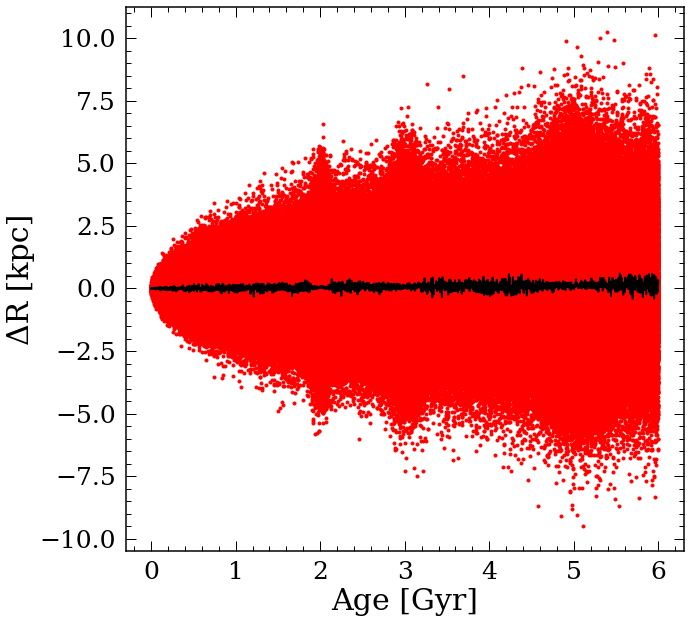

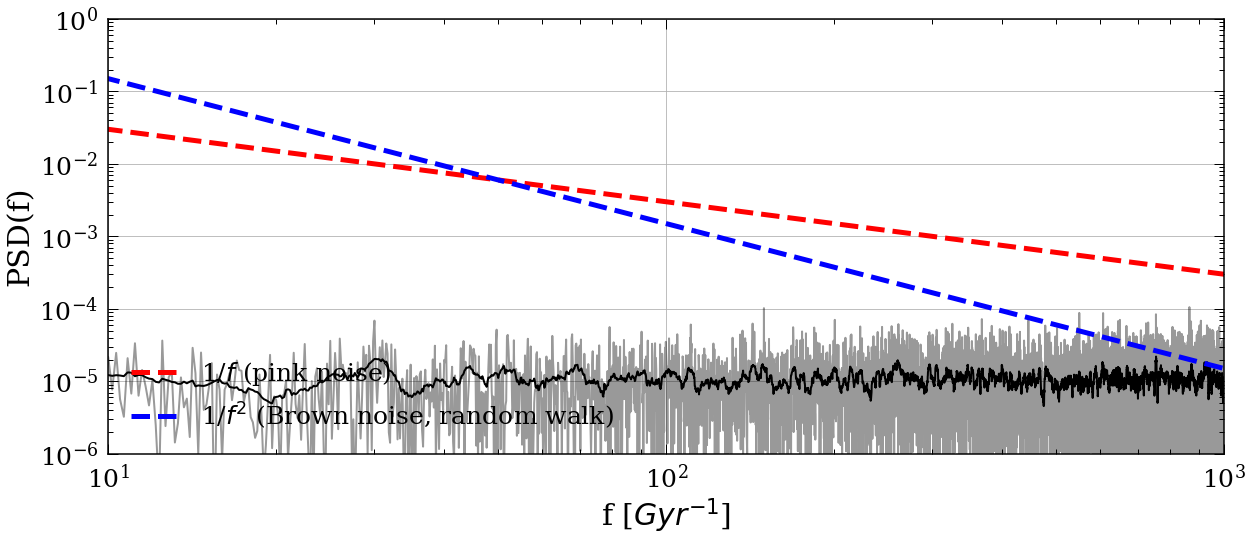

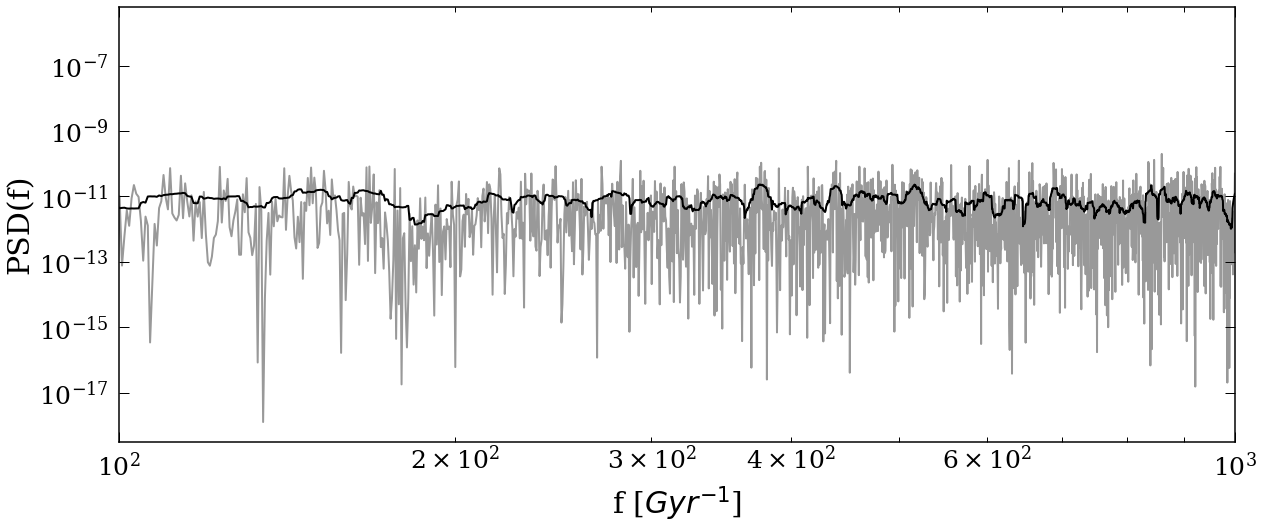

In [13]:
age, dr = processdata(sqrttest)

age_order, dr_order = zip(*sorted(zip(age, dr)))
age_smooth, dr_smooth = SlideMed(age_order, dr_order, 0.0025/2, 0.0025)

plt.figure()
plt.plot(age, dr,'r.')
plt.plot(age_smooth, dr_smooth,'k-')
plt.xlabel('Age [Gyr]')
plt.ylabel('ΔR [kpc]')

### FFT
N = len(age)
T = max(age)/N
yf = fft(dr)

xf = fftfreq(N, T)[:N//2]

plt.figure(figsize=(20,8))
PSD = 2.0/N * np.abs(yf[0:N//2])
plt.loglog(xf,PSD**2,'k-',alpha=0.4)

PSD_smooth = savgol_filter(PSD**2, 21, 1)
plt.loglog(xf,PSD_smooth,'k-')

A = 0.3
plt.plot(xf, A/xf, 'r--',label='1/$f$ (pink noise)',linewidth=5)
plt.plot(xf, A*50/xf**2, 'b--',label='1/$f^2$ (Brown noise, random walk)',linewidth=5)
plt.grid()
plt.xlim([10,1e3])
plt.ylim([1e-6,1])
plt.xlabel('f [$Gyr^{-1}$]')
plt.ylabel('PSD(f)')
plt.legend(loc=3)


### LG
power = LombScargle(age_order, dr_order).power(np.linspace(0.1,1e3,2000))
plt.figure(figsize=(20,8))
PSD = np.array(power,dtype=float)
plt.loglog(np.linspace(0.1,1e3,2000), PSD**2,'k-',alpha=0.4)
PSD_smooth = savgol_filter(PSD**2, 21, 1)
plt.loglog(np.linspace(0.1,1e3,2000),PSD_smooth,'k-')
plt.xlabel('f [$Gyr^{-1}$]')
plt.ylabel('PSD(f)')
plt.xlim([100,1e3])
#plt.ylim([0,1])